In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
#import cv2
import matplotlib.pyplot as plt
import datetime
from tensorflow import Tensor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data from GGDrive

In [3]:
npzfile = np.load('/content/drive/MyDrive/Colab Notebooks/Hackathon/my_data_4stride_2.npz')
print(npzfile.files)
img_sample = npzfile['img_sample']
img_label = npzfile['img_label']

['img_sample', 'img_label']


# Define model architecture

In [4]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16,ResNet50,EfficientNetB2,InceptionV3,EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Activation, Dropout, Flatten, Dense, Conv2DTranspose, concatenate, UpSampling2D

In [5]:
# KERAS UNET 
start_neurons = 64
input_layer = keras.Input(shape=(40,40,12),dtype='float32')
# scaled = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
aug = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(input_layer)
aug = layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='constant')(aug)
# aug = layers.experimental.preprocessing.RandomContrast(0.5)(aug)

conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(aug)
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.25)(pool2)

conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(0.25)(pool3)

# Middle
convm = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
convm = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(convm)

deconv3 = UpSampling2D(size=(2, 2))(convm)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(0.25)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2 = UpSampling2D(size=(2, 2))(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(0.25)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

deconv1 = UpSampling2D(size=(2, 2))(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(0.25)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
output_layer = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

#output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

gap_out = keras.layers.GlobalAveragePooling2D()(output_layer)
# --- Dense Layer ---
output = Dense(4, activation='softmax')(gap_out)
#-----------------------------------------------------------------
model = keras.Model(inputs=input_layer, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 40, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 random_flip (RandomFlip)       (None, 40, 40, 12)   0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 40, 40, 12)  0           ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [6]:
keras.utils.plot_model(model, show_shapes=True)

# Train-Test split

In [9]:
from sklearn.model_selection import train_test_split
img_label_onehot = tf.keras.utils.to_categorical(img_label-1)
train_sample, test_sample, train_label, test_label = train_test_split(img_sample, img_label_onehot, test_size=0.25, random_state=2374)

# Model compile

In [10]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=False)
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode = 'min',restore_best_weights=True)]

# Model Training

In [11]:
history = model.fit(x=train_sample, y=train_label, batch_size=16, epochs=600
                    ,validation_data=(test_sample,test_label),verbose=1,
                    callbacks=callback_list)

Epoch 1/600
750/750 [==============================] - 22s 22ms/step - loss: 1.3497 - accuracy: 0.3166 - val_loss: 1.3220 - val_accuracy: 0.3515
Epoch 2/600
750/750 [==============================] - 16s 22ms/step - loss: 1.3029 - accuracy: 0.3716 - val_loss: 1.2900 - val_accuracy: 0.3880
Epoch 3/600
750/750 [==============================] - 15s 20ms/step - loss: 1.2781 - accuracy: 0.3956 - val_loss: 1.2512 - val_accuracy: 0.4257
Epoch 4/600
750/750 [==============================] - 17s 22ms/step - loss: 1.2379 - accuracy: 0.4220 - val_loss: 1.2170 - val_accuracy: 0.4293
Epoch 5/600
750/750 [==============================] - 15s 20ms/step - loss: 1.1814 - accuracy: 0.4678 - val_loss: 1.1505 - val_accuracy: 0.4920
Epoch 6/600
750/750 [==============================] - 15s 20ms/step - loss: 1.1231 - accuracy: 0.5110 - val_loss: 1.1786 - val_accuracy: 0.4890
Epoch 7/600
750/750 [==============================] - 15s 20ms/step - loss: 1.0822 - accuracy: 0.5321 - val_loss: 1.1322 - val_ac

In [12]:
#tf.keras.models.save_model(model,'/content/drive/MyDrive/Colab Notebooks/Hackathon/my_lovely_unet_4.h5')

# Model Accuracy and Loss

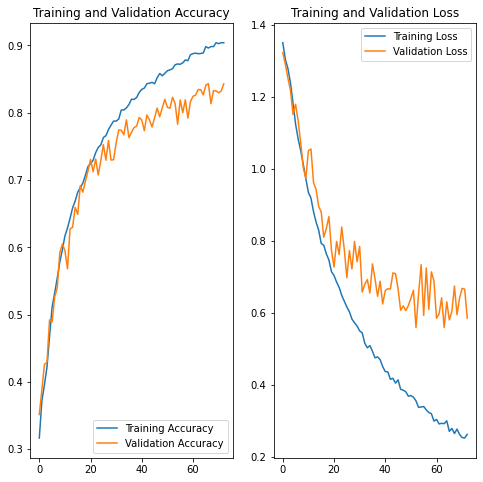

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

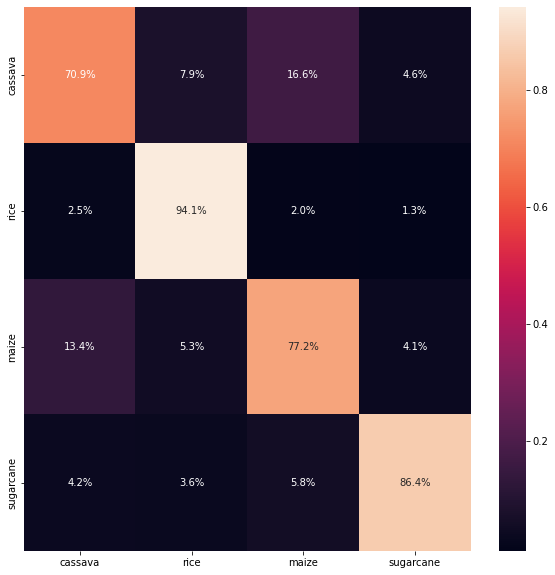

In [14]:
predicted_result = model.predict(test_sample)
predicted_class = np.argmax(predicted_result,axis=1)
ground_truth_class = np.argmax(test_label,axis=1)
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(ground_truth_class, predicted_class,normalize='true')
import seaborn as sns
crop_class = ["cassava","rice","maize","sugarcane"]
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix,annot=True,fmt=".1%",xticklabels=crop_class,yticklabels=crop_class)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth_class, predicted_class))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       984
           1       0.85      0.94      0.89       989
           2       0.75      0.77      0.76       973
           3       0.90      0.86      0.88      1054

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



In [16]:
test_set = np.load('/content/drive/MyDrive/Colab Notebooks/Hackathon/team_test.npy')

In [17]:
test_set_pred = model.predict(test_set)
test_set_class = np.argmax(test_set_pred,axis=1)
crop_type = test_set_class+1

In [21]:
import pandas as pd
df = pd.Series(crop_type,name='crop_type').to_frame()
df.to_csv('predict.csv')